## 0. Loading Data

In [1]:
import pandas as pd

# Load the CSV file into a DataFrame with low_memory=False to avoid DtypeWarning
data = pd.read_csv('msna_data.csv', low_memory=False)

## 1. Data Exploration

This code performs **explanatory data analysis** (EDA) on a dataset, focusing on correlation analysis, skewness, and variance inflation factor (VIF) for numeric features. It also handles label encoding of categorical variables, cross-tabulation, and hierarchical clustering for visualizing relationships between categories. Finally, the results are exported for further analysis.

**Key Steps:**

1. **Label Encoding for Categorical Variables**:
   - The function `encode_categorical_columns(df)` uses `LabelEncoder` to convert categorical variables into numeric form, ensuring that no NaN values are introduced during conversion. This step is essential for preparing the dataset for correlation and regression analysis.

2. **Correlation and Explanatory Analysis**:
   - The `explanatory_analysis(df, target)` function calculates various statistical metrics for each feature in relation to the target variable, including:
     - **Pearson correlation and p-value**.
     - **Spearman correlation and p-value**.
     - **Kendall's Tau correlation and p-value**.
     - **Skewness**: To measure asymmetry in the distribution of each feature.
     - **Variance Inflation Factor (VIF)**: To detect multicollinearity between features.

3. **Cross-Tabulation**:
   - A **cross-tabulation** of the `msna` categories and the target variable (`child_sep_severity_family_reun_required`) is created to analyze the proportion of the target values within each category.

4. **Hierarchical Clustering**:
   - **Hierarchical clustering** is performed using the `ward` linkage method on the cross-tabulated data to group `msna` categories based on the distribution of the target variable.
   - A **dendrogram** is plotted to visualize the relationships between the clusters of `msna` categories.

5. **Data Visualization**:
   - A bar plot visualizes the frequency distribution of the `msna` categories.
   - A dendrogram visualizes the hierarchical clustering of the `msna` categories based on the target distribution.

6. **Exporting Results**:
   - The correlation analysis table is saved as an Excel file (`eda_corr_table.xlsx`) for further review or documentation.

                                         Variable  Pearson Correlation  \
60    child_sep_severity_all_family_reun_required             1.000000   
9                         child_sep_reasons_given             0.225001   
5                             children_outside_hh             0.225001   
6                         children_outside_hh_all             0.225001   
55                        children_outside_hh_yes             0.225001   
..                                            ...                  ...   
61  child_sep_severity_all_no_children_outside_hh            -0.225001   
58      child_sep_severity_no_children_outside_hh            -0.225001   
56                     children_outside_hh_all_no            -0.225001   
8                          child_sep_severity_all            -0.459017   
7                              child_sep_severity            -0.459017   

    Pearson P-Value  Spearman Correlation  Spearman P-Value  \
60              0.0              1.000000       

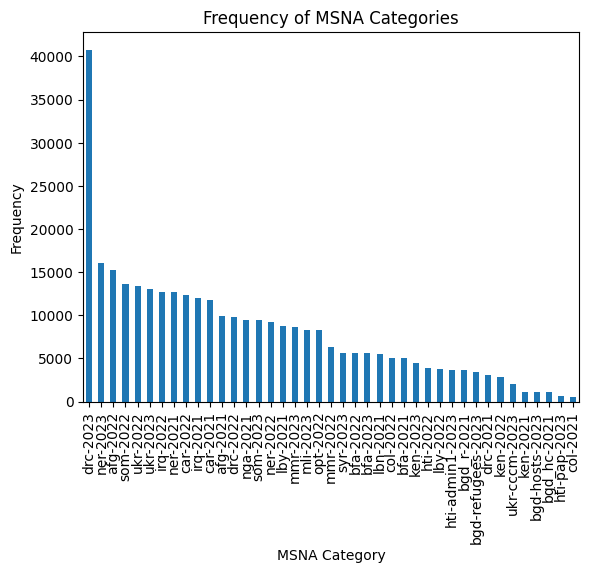

In [2]:
import missingno as msno
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr, spearmanr, kendalltau, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd

# Label encode any categorical variables to ensure no NaNs during conversion
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns before converting them to numeric
def encode_categorical_columns(df):
    for col in df.select_dtypes(include=['object', 'category']).columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
    return df

# Apply encoding to categorical columns
encoded_data = encode_categorical_columns(data.copy())

# Now convert to numeric (this step will not introduce NaNs because categorical columns are now encoded)
numeric_data = encoded_data.apply(pd.to_numeric, errors='coerce')

# Function to calculate correlations, p-values, and other explanatory metrics
def explanatory_analysis(df, target):
    variables = df.columns[df.columns != target]
    results = {
        'Variable': [],
        'Pearson Correlation': [],
        'Pearson P-Value': [],
        'Spearman Correlation': [],
        'Spearman P-Value': [],
        'Kendall Tau Correlation': [],
        'Kendall P-Value': [],
        'Skewness': [],
        'Variance Inflation Factor (VIF)': []
    }

    for col in variables:
        clean_df = df[[col, target]].dropna()

        # Check if the column has enough variability (at least 2 unique values)
        if len(clean_df) >= 2 and clean_df[col].nunique() > 1 and clean_df[target].nunique() > 1:
            # Pearson correlation and p-value
            pearson_corr, pearson_p = pearsonr(clean_df[col], clean_df[target])

            # Spearman correlation and p-value (only if there's variability)
            spearman_corr, spearman_p = spearmanr(clean_df[col], clean_df[target]) if clean_df[col].nunique() > 1 else (np.nan, np.nan)

            # Kendall's Tau correlation and p-value (only if there's variability)
            kendall_corr, kendall_p = kendalltau(clean_df[col], clean_df[target]) if clean_df[col].nunique() > 1 else (np.nan, np.nan)

            # Skewness (calculate only if variability exists)
            skewness = skew(clean_df[col]) if clean_df[col].nunique() > 1 else np.nan

            # VIF calculation (handled similarly)
            try:
                vif = variance_inflation_factor(df.dropna().values, df.columns.get_loc(col))
            except:
                vif = np.nan  # Handle cases where VIF cannot be computed

            # Append results to the appropriate lists
            results['Variable'].append(col)
            results['Pearson Correlation'].append(pearson_corr)
            results['Pearson P-Value'].append(pearson_p)
            results['Spearman Correlation'].append(spearman_corr)
            results['Spearman P-Value'].append(spearman_p)
            results['Kendall Tau Correlation'].append(kendall_corr)
            results['Kendall P-Value'].append(kendall_p)
            results['Skewness'].append(skewness)
            results['Variance Inflation Factor (VIF)'].append(vif)

    # Return the results as a DataFrame
    return pd.DataFrame(results).sort_values(by='Pearson Correlation', ascending=False)

# Apply the function for explanatory analysis on all numeric variables
explanatory_table = explanatory_analysis(numeric_data, 'child_sep_severity_family_reun_required')

# Print the explanatory analysis table
print(explanatory_table)

# Export the DataFrame to an Excel file
explanatory_table.to_excel("eda_corr_table.xlsx", index=False)

# Check the frequency of each category in 'msna'
msna_freq = data['msna'].value_counts()

# Print the frequency of each category in msna
print("Frequency of each category in 'msna':")
print(msna_freq)

# Visualize the distribution of msna categories
msna_freq.plot(kind='bar')
plt.title('Frequency of MSNA Categories')
plt.xlabel('MSNA Category')
plt.ylabel('Frequency')
plt.show()


## 2. Data Cleaning

This script cleans and prepares a dataset for analysis by handling missing data, dropping irrelevant columns, and visualizing the changes.

**Key Steps**

1. **Import Libraries**: Uses `pandas`, `matplotlib.pyplot`, and `missingno` for data manipulation and visualization.
2. **Drop Columns with Conditions**: Defines a function to drop columns based on missing values, zero variance, or specific patterns.
3. **Filter Data**: Removes rows with missing values in the `child_sep_severity` column.
4. **Select Variables**: Loads pre-selected variables from `vars_analysis.csv` and drops aggregated age columns.
5. **Handle Missing Values**: Drops columns with >20% missing data and columns with zero variance.
6. **Remove '_NA' Columns**: Drops columns ending with '_NA'.
7. **Visualize Missing Data**: Visualizes missing data before and after column removal.
8. **Final DataFrame Info**: Prints the final cleaned DataFrame structure.


Shape of the filtered DataFrame, without missing values for the response variable: (268511, 199)

Dropped columns with more than 20% missing values:
['lcsi_cat', 'hoh_age', 'rcsi_score', 'fsl_fc_cell', 'wgq_dis_4_n', 'wgq_dis_3_n', 'wgq_dis_2_n', 'fatalities_3m', 'events_3m', 'fatalities_6m', 'events_6m', 'fatalities_1y', 'events_1y', 'displ_status_specific_idp_non_site', 'displ_status_specific_idp_returnee', 'displ_status_specific_idp_site', 'received_assistance_3m_dnk', 'received_assistance_3m_dwta', 'received_assistance_3m_yes', 'received_assistance_6m_dnk', 'received_assistance_6m_dwta', 'received_assistance_6m_yes', 'received_assistance_12m_dnk', 'received_assistance_12m_dwta', 'received_assistance_12m_yes']


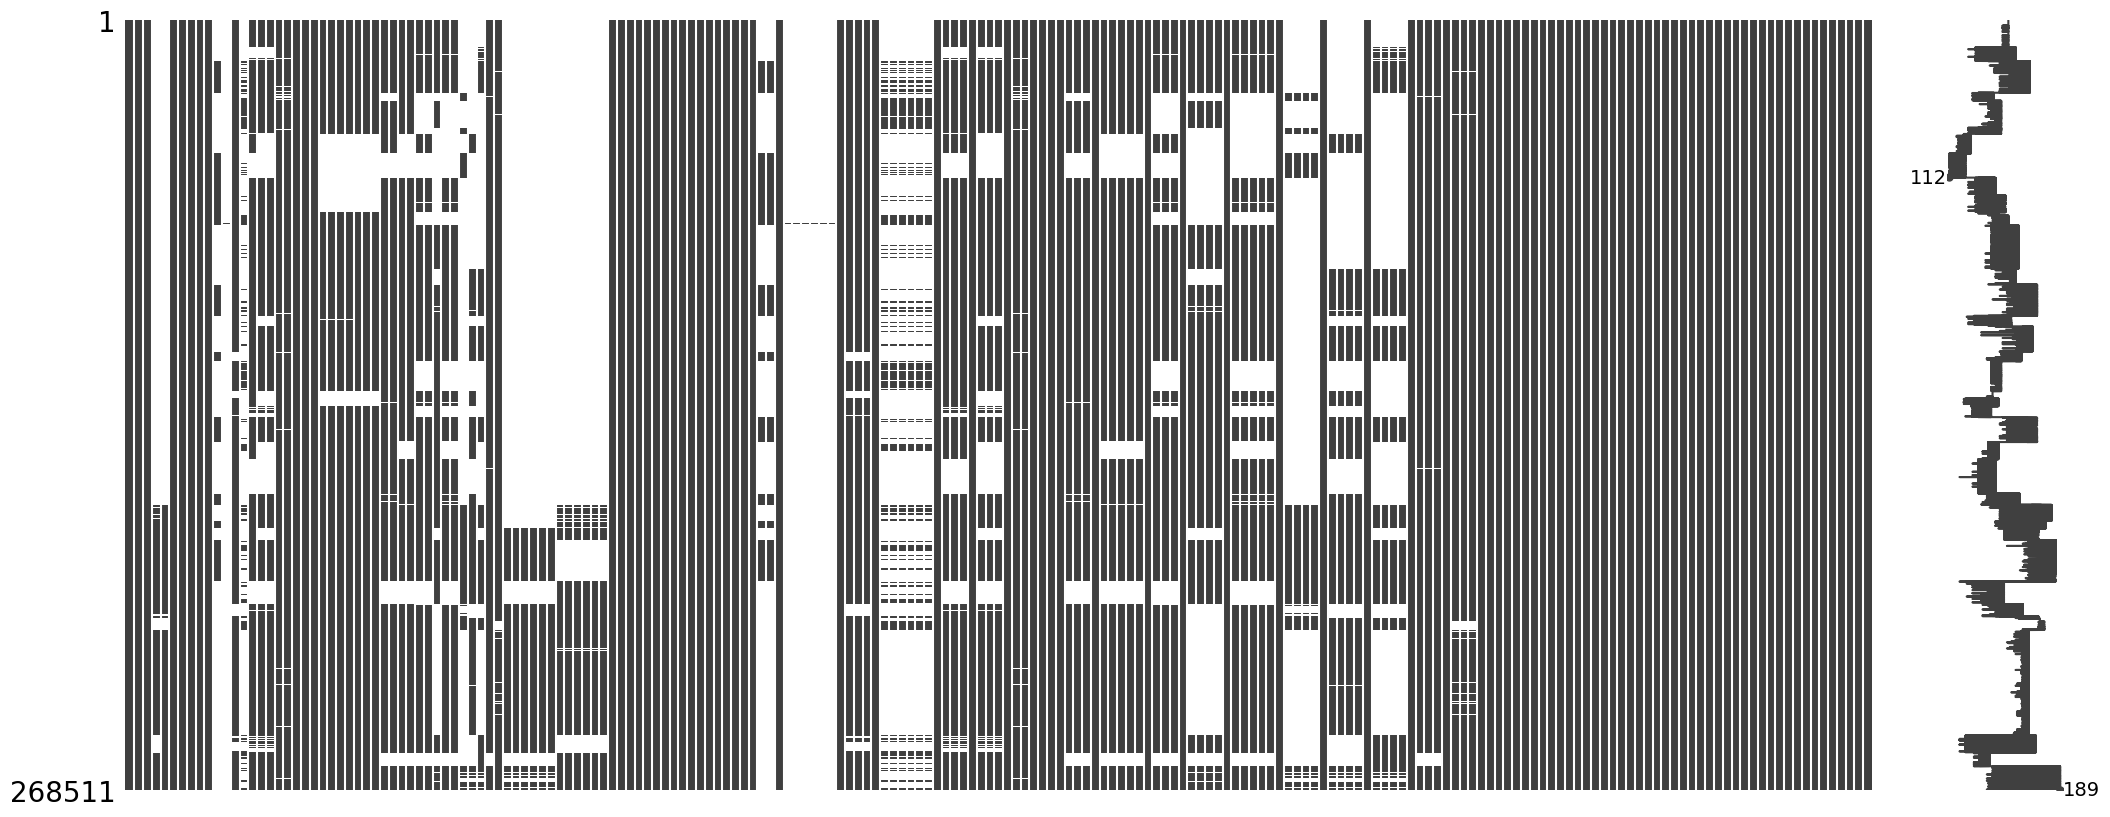

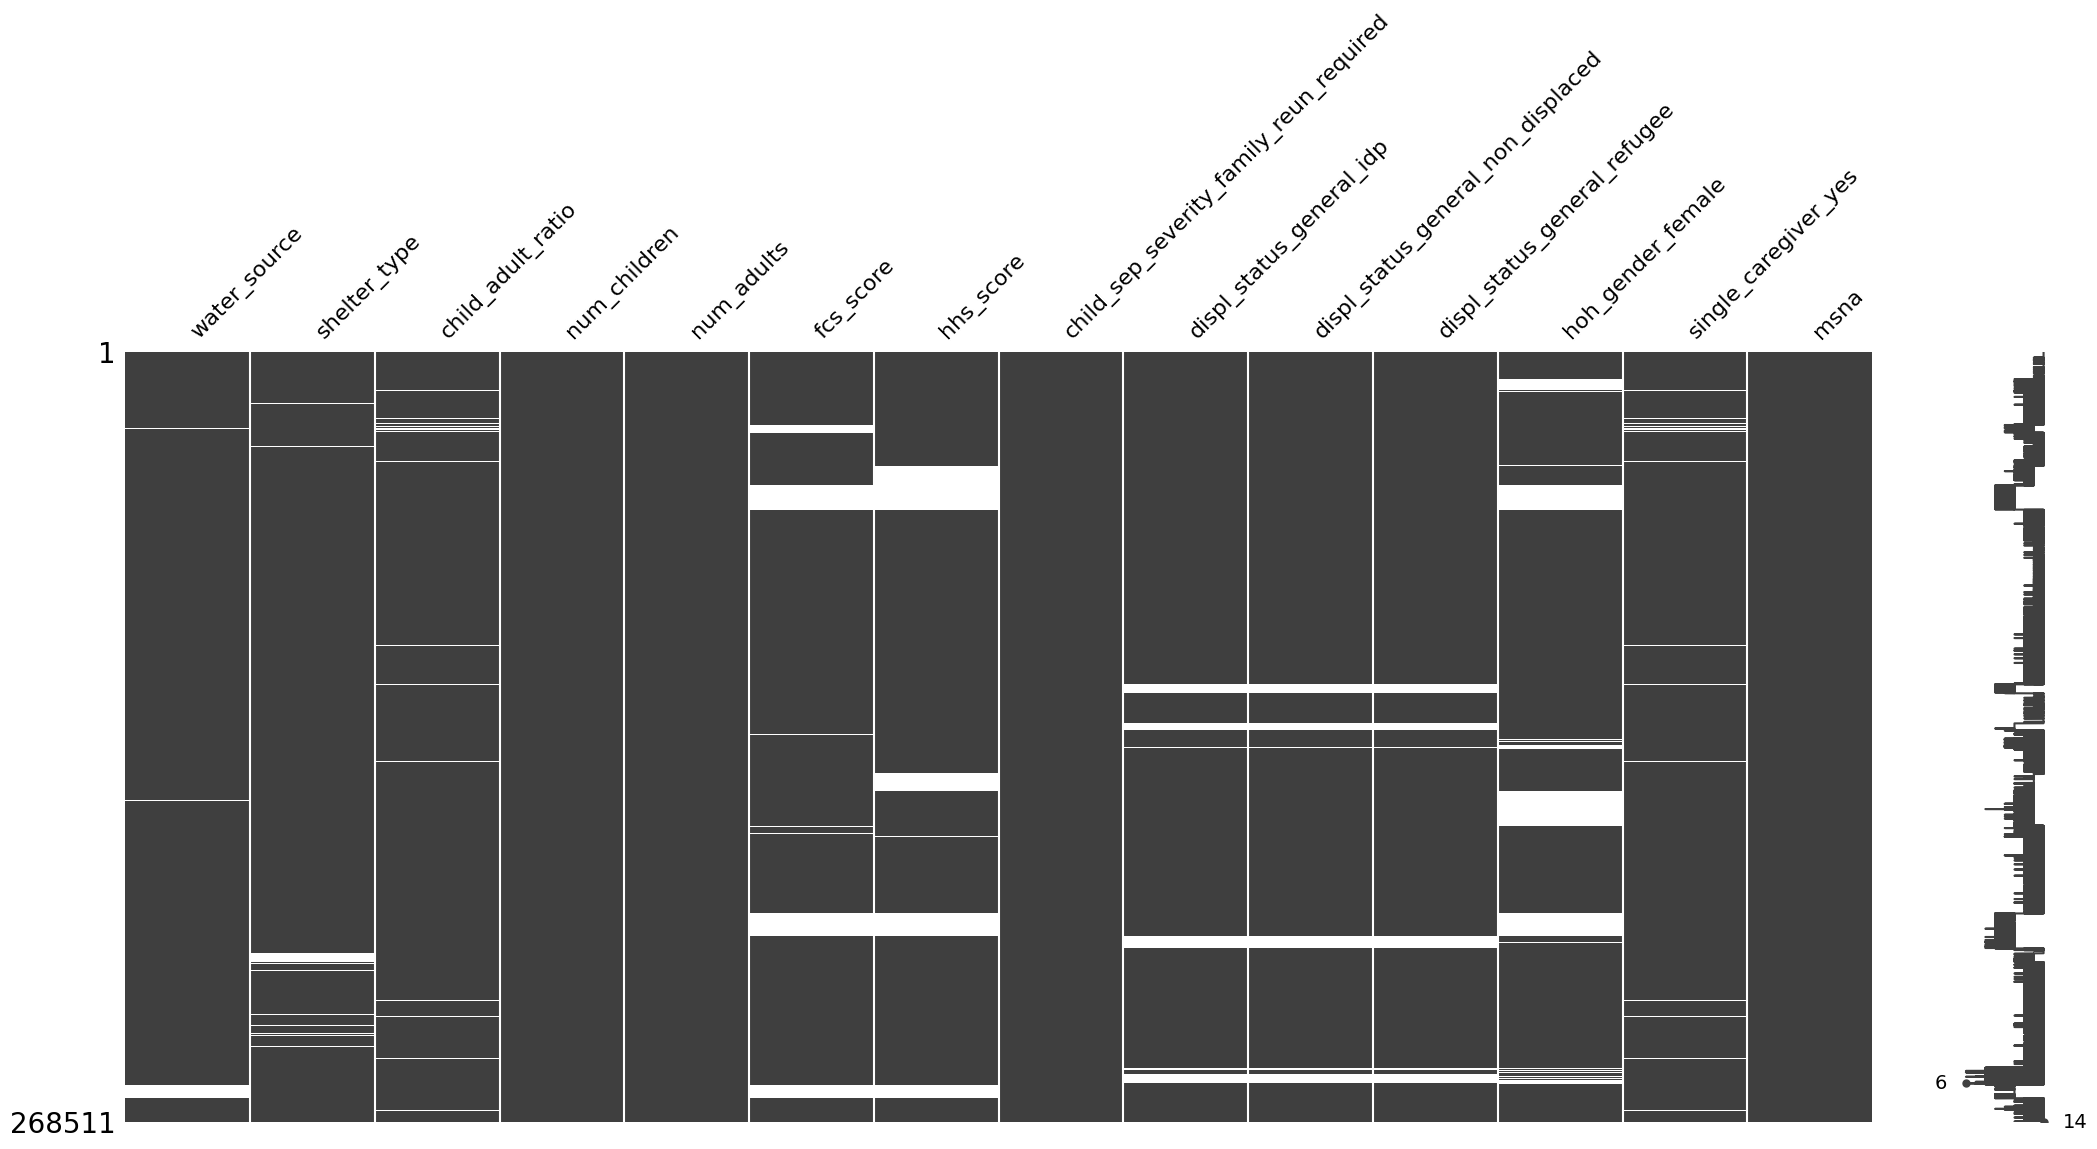


Final DataFrame after dropping unnecessary columns:
<class 'pandas.core.frame.DataFrame'>
Index: 268511 entries, 0 to 329442
Data columns (total 14 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   water_source                             263014 non-null  object 
 1   shelter_type                             262333 non-null  object 
 2   child_adult_ratio                        264081 non-null  float64
 3   num_children                             268510 non-null  float64
 4   num_adults                               268505 non-null  float64
 5   fcs_score                                241856 non-null  float64
 6   hhs_score                                232900 non-null  float64
 7   child_sep_severity_family_reun_required  268511 non-null  float64
 8   displ_status_general_idp                 255168 non-null  float64
 9   displ_status_general_non_displaced       255168 non-nul

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

# Define function to display and drop columns based on a condition
def drop_columns_with_condition(df, condition, description):
    columns_to_drop = df.columns[condition].tolist()
    if columns_to_drop:
        print(f"\nDropped columns {description}:")
        print(columns_to_drop)
        return df.drop(columns=columns_to_drop)
    return df

# Filter out rows with missing values in the 'child_sep_severity' column
data_filtered = data.dropna(subset=['child_sep_severity'])
print("\nShape of the filtered DataFrame, without missing values for the response variable:", data_filtered.shape)

# Load variables to consider for the model (that are not redundant because based on same data)
vars_analysis = pd.read_csv('vars_analysis.csv')['variable'].tolist()

# Exclude columns that are redundant because based on same data
data_select = data_filtered[vars_analysis].copy()

# Identify columns with more than 20% missing values
missing_percentage = data_select.isnull().mean() * 100
columns_with_many_missing = missing_percentage > 20

# Drop columns with more than 20% missing values
data_select = drop_columns_with_condition(data_select, columns_with_many_missing, "with more than 20% missing values")

# Drop columns with zero variance (only one unique value)
zero_variance_condition = data_select.nunique() <= 1
data_select = drop_columns_with_condition(data_select, zero_variance_condition, "with zero variance")

# Identify and drop variables ending with '_NA'
na_columns = [col for col in data_select.columns if col.endswith('_NA')]
data_select = drop_columns_with_condition(data_select, data_select.columns.isin(na_columns), "'_NA' columns")

# Visualize missing data matrix before and after dropping columns
msno.matrix(data_filtered)
plt.show()
msno.matrix(data_select)
plt.show()

# Display final DataFrame info
print("\nFinal DataFrame after dropping unnecessary columns:")
data_select.info()


## 3. Feature Engineering 


Old and New Labels after Relabeling:
       variable      label_old  label_new
0  shelter_type       adequate          1
1  shelter_type     inadequate          2
2  shelter_type     no_shelter          3
3  water_source       improved          1
4  water_source     unimproved          2
5  water_source  surface_water          3


C:\Users\jasper.linke\AppData\Local\Temp\ipykernel_18440\2752330500.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_fe[variable] = data_fe[variable].replace(label_old, label_new)


Cross-tabulation of msna categories and target values
child_sep_severity_family_reun_required       0.0       1.0
msna                                                       
afg-2021                                 0.999262  0.000738
afg-2022                                 0.999869  0.000131
bfa-2021                                 0.996712  0.003288
bfa-2022                                 0.997073  0.002927
bfa-2023                                 0.997325  0.002675
bgd-hosts-2023                           1.000000  0.000000
bgd-refugees-2023                        0.997026  0.002974
bgd_hc-2021                              0.999040  0.000960
bgd_r-2021                               0.999707  0.000293
car-2021                                 0.958882  0.041118
car-2022                                 0.995492  0.004508
col-2022                                 0.999729  0.000271
drc-2021                                 0.996414  0.003586
drc-2022                                 0.996

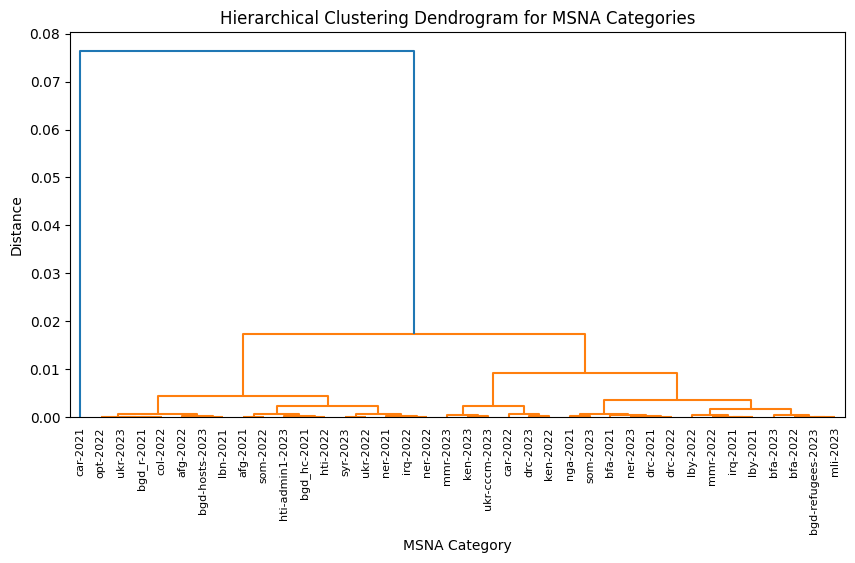

n_clusters = 2, silhouette score = 0.922889488695832
n_clusters = 3, silhouette score = 0.5600995281782164
n_clusters = 4, silhouette score = 0.5928724897930049
n_clusters = 5, silhouette score = 0.5515882722120772
n_clusters = 6, silhouette score = 0.5394419479842949
n_clusters = 7, silhouette score = 0.5800312135342265
n_clusters = 8, silhouette score = 0.5959069433828575
n_clusters = 9, silhouette score = 0.6343305564230386
n_clusters = 10, silhouette score = 0.6217199493253743
Best number of clusters: 2, with silhouette score: 0.922889488695832


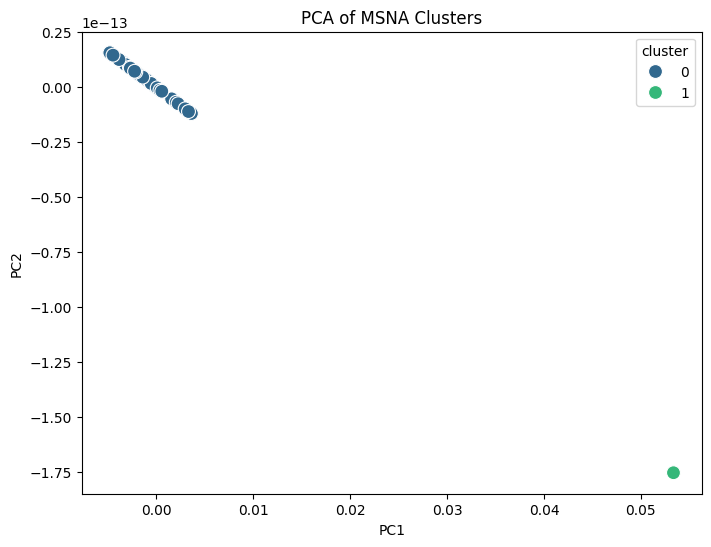

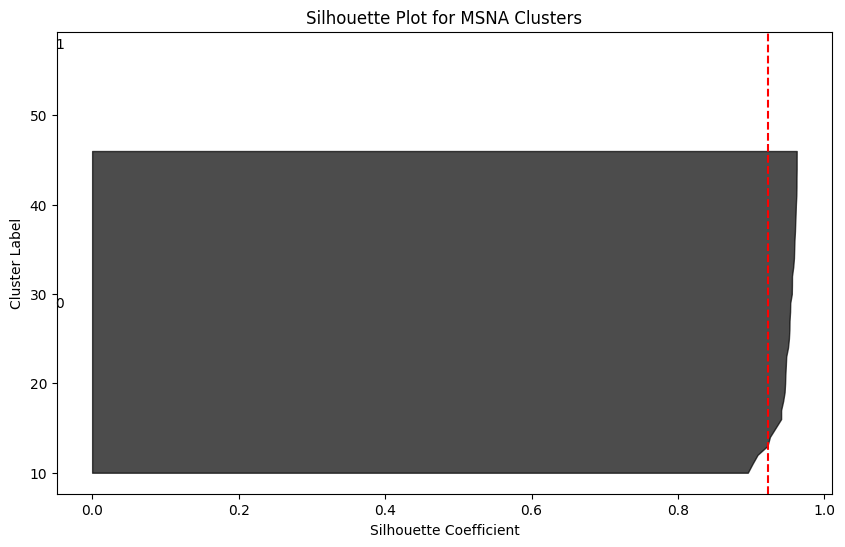

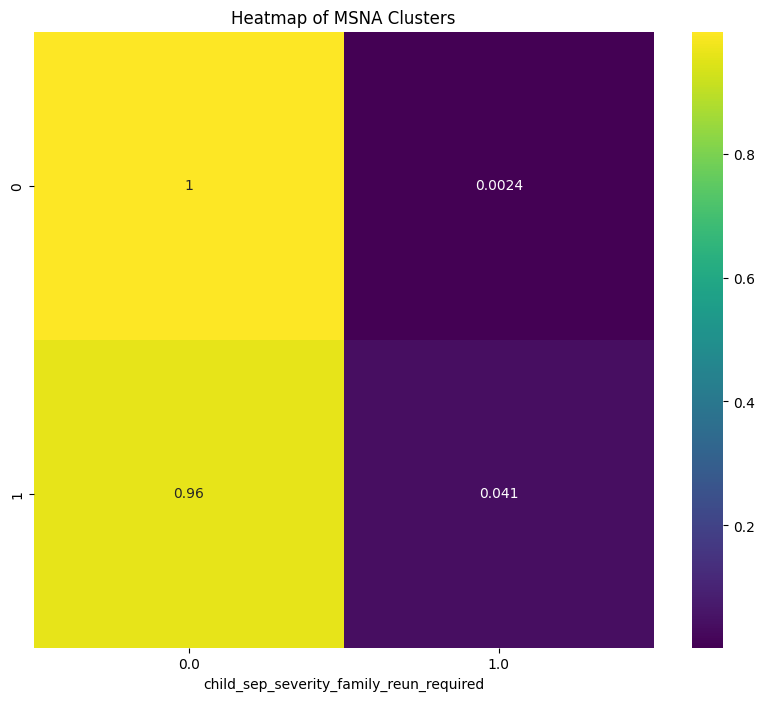


Clusters and their corresponding MSNA values:
cluster
0    [afg-2021, afg-2022, bfa-2021, bfa-2022, bfa-2...
1                                           [car-2021]
Name: msna, dtype: object


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
from sklearn.decomposition import PCA

# Load the new_labels CSV file and filter for variables present in the data
new_labels = pd.read_csv('new_labels.csv', usecols=['variable', 'label_old', 'label_new'])
new_labels = new_labels[new_labels['variable'].isin(data_select.columns)]

# Print old and new labels after relabeling
print("\nOld and New Labels after Relabeling:")
print(new_labels)

# Create a copy of data_select to apply changes
data_fe = data_select.copy()

# Apply the label mapping to the data_fe DataFrame
for _, row in new_labels.iterrows():
    variable = row['variable']
    label_old = row['label_old']
    label_new = int(row['label_new'])  # Convert label_new to integer
    
    if variable in data_fe.columns:
        data_fe[variable] = data_fe[variable].replace(label_old, label_new)

# Define recoded_variables
recoded_variables = new_labels['variable'].unique()

# Convert the recoded variables to integer type
for variable in recoded_variables:
    if variable in data_fe.columns:
        data_fe[variable] = data_fe[variable].fillna(pd.NA).astype('Int64')

# Apply log transformation to specific variables if they exist in the dataset
log_transform_vars = ['fcs_score', 'hhs_score', 'rcsi_score', 'fsl_fc_cell']

for var in log_transform_vars:
    if var in data_fe.columns:
        # Log transform the variable, adding a small constant (1) to avoid log(0)
        data_fe[f'{var}_log'] = np.log(data_fe[var] + 1)

# Cross-tabulation of MSNA categories and target values
print("Cross-tabulation of msna categories and target values")
target_dist_by_msna = pd.crosstab(data['msna'], data['child_sep_severity_family_reun_required'], normalize='index')
print(target_dist_by_msna)

# Perform hierarchical clustering using the linkage matrix
linkage_matrix = linkage(target_dist_by_msna, method='ward')

# Plot the dendrogram to visualize category clustering
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=target_dist_by_msna.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram for MSNA Categories')
plt.xlabel('MSNA Category')
plt.ylabel('Distance')
plt.show()

# Range of cluster numbers to try
min_clusters = 2
max_clusters = 10
best_score = -1
best_n_clusters = None

# Loop over a range of cluster sizes to find the best number of clusters
for n_clusters in range(min_clusters, max_clusters + 1):
    cluster_model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    cluster_labels = cluster_model.fit_predict(target_dist_by_msna)
    
    # Calculate silhouette score
    if len(set(cluster_labels)) > 1:  # Ensure more than one cluster exists
        score = silhouette_score(target_dist_by_msna, cluster_labels)
        print(f"n_clusters = {n_clusters}, silhouette score = {score}")
        
        # Track the best score and corresponding number of clusters
        if score > best_score:
            best_score = score
            best_n_clusters = n_clusters

# Print the best number of clusters
print(f"Best number of clusters: {best_n_clusters}, with silhouette score: {best_score}")

# Now apply the best cluster size for AgglomerativeClustering
cluster_model = AgglomerativeClustering(n_clusters=best_n_clusters, metric='euclidean', linkage='ward')
msna_clusters = cluster_model.fit_predict(target_dist_by_msna)

# 1. **Scatter Plot of Clusters using PCA (2D Visualization)**

# Perform PCA to reduce data to two dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(target_dist_by_msna)  # Using the same data used for clustering
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Add cluster labels from msna_clusters to the PCA DataFrame
pca_df['cluster'] = msna_clusters

# Plot the PCA result, with points colored by cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', s=100)
plt.title('PCA of MSNA Clusters')
plt.show()

# 2. **Silhouette Plot**

# Calculate silhouette scores for each sample based on msna_clusters
silhouette_values = silhouette_samples(target_dist_by_msna, msna_clusters)

# Silhouette plot
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(best_n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i
    ith_cluster_silhouette_values = silhouette_values[msna_clusters == i]
    
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / best_n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 10 for the 0 samples
    
plt.title('Silhouette Plot for MSNA Clusters')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster Label')
plt.axvline(x=silhouette_values.mean(), color="red", linestyle="--")
plt.show()

# 3. **Cluster Heatmap**

# Generate a heatmap to show feature contribution per cluster, grouped by the clusters from msna_clusters
plt.figure(figsize=(10, 8))
sns.heatmap(target_dist_by_msna.groupby(msna_clusters).mean(), cmap='viridis', annot=True)
plt.title('Heatmap of MSNA Clusters')
plt.show()

# 4. **Map the Clusters to Full Dataset `data_fe`**

# Create a DataFrame to show the MSNA categories and their corresponding clusters
clustered_df = pd.DataFrame({
    'msna': target_dist_by_msna.index,  # The unique MSNA categories from the cross-tab
    'cluster': msna_clusters            # The cluster labels from the clustering
})

# Show which clusters include which original MSNA values
print("\nClusters and their corresponding MSNA values:")
print(clustered_df.groupby('cluster')['msna'].apply(list))

# Now map the clusters to the full data (data_fe) based on the 'msna' variable
# First, create a mapping from MSNA categories to their clusters
msna_cluster_map = clustered_df.set_index('msna')['cluster'].to_dict()

# Now use this mapping to assign cluster labels to each row in the full dataset (data_fe)
# Assuming 'msna' exists in data_fe, map the clusters back to the full data
data_fe['cluster'] = data_fe['msna'].map(msna_cluster_map)

# Handle rows with MSNA categories that are not in the clustered dataset (if any)
# These will be NaN after the mapping, so you can either drop them or assign them to a default cluster
data_fe['cluster'] = data_fe['cluster'].fillna(-1)  # Optionally assign -1 for unclustered categories

# Exclude 'msna' from the DataFrame before exporting
data_fe = data_fe.drop(columns=['msna'])

# Now the DataFrame is ready, and you can export it to a pickle file
data_fe.to_pickle('data_fe.pkl')


## 4. Imputation of Missing Values


Integer columns: ['shelter_type', 'child_sep_severity_family_reun_required', 'displ_status_general_idp', 'displ_status_general_refugee', 'cluster', 'water_source', 'displ_status_general_non_displaced', 'hoh_gender_female', 'single_caregiver_yes']


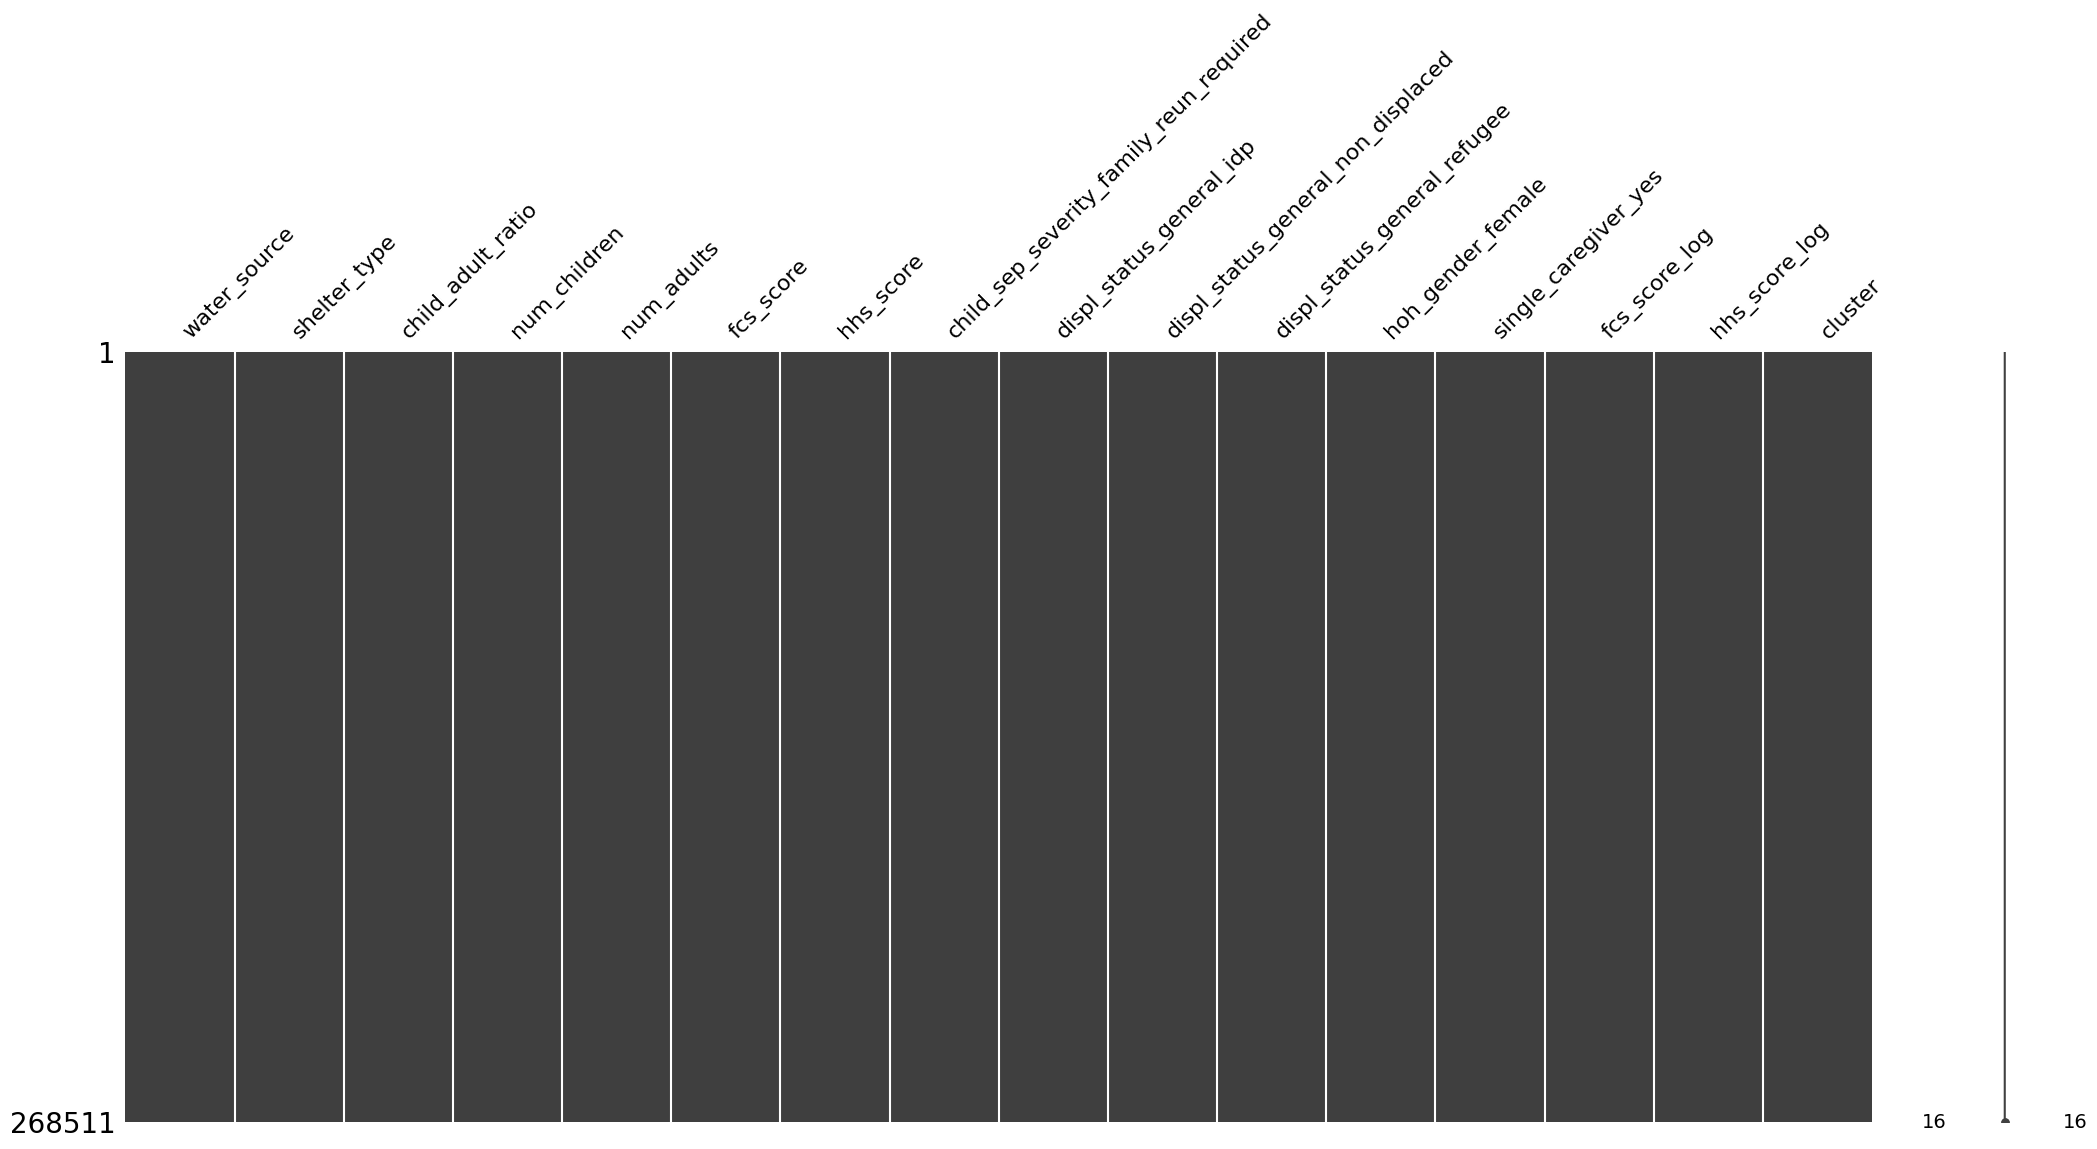


DataFrame with imputed values:
   water_source  shelter_type  child_adult_ratio  num_children  num_adults  \
0           1.0           1.0                0.2           1.0         5.0   
1           1.0           1.0                2.5           5.0         2.0   
2           1.0           1.0                2.0           4.0         2.0   
3           1.0           1.0                2.0           4.0         2.0   
4           2.0           1.0                2.5           5.0         2.0   

   fcs_score  hhs_score  child_sep_severity_family_reun_required  \
0       40.0        0.0                                      0.0   
1       34.5        0.0                                      0.0   
2       25.0        0.0                                      0.0   
3       40.0        0.0                                      0.0   
4       29.5        0.0                                      0.0   

   displ_status_general_idp  displ_status_general_non_displaced  \
0                      

In [5]:
import pandas as pd
import pickle
from sklearn.impute import KNNImputer
import missingno as msno
import matplotlib.pyplot as plt

# Load the data_fe DataFrame from the pickle file
with open('data_fe.pkl', 'rb') as f:
    data_fe = pickle.load(f)

# Function to apply K-Nearest Neighbors Imputation to all columns
def knn_impute_all_columns(df, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df_imputed

# Apply KNN imputation to all columns
data_na_imp = knn_impute_all_columns(data_fe.copy())

# Identify binary columns (those with only two unique values: 0 and 1, or 1.0 and 0.0, including missing values)
binary_columns = [col for col in data_fe.columns if data_fe[col].dropna().nunique() == 2 and set(data_fe[col].dropna().unique()).issubset({0, 1, 0.0, 1.0})]

# Identify integer columns
integer_columns = data_fe.select_dtypes(include=['int64']).columns.tolist()

# Add binary columns to integer columns, ensuring no duplicates
integer_columns = list(set(integer_columns + binary_columns))

# Print the integer columns
print("Integer columns:", integer_columns)

# Ensure rounding is applied only to numeric columns that can be rounded
numeric_columns_to_round = [col for col in integer_columns if col in data_na_imp.columns and pd.api.types.is_numeric_dtype(data_na_imp[col])]

# Round the integer variables to ensure no impossible values are imputed
data_na_imp[numeric_columns_to_round] = data_na_imp[numeric_columns_to_round].round()

# Visualize missing data matrix after imputation
msno.matrix(data_na_imp)
plt.show()

# Display the first few rows of the new dataframe with imputed values
print("\nDataFrame with imputed values:")
print(data_na_imp.head())

# Saving the DataFrame as a pickle file
with open('data_na_imp.pkl', 'wb') as f:
    pickle.dump(data_na_imp, f)


## 5. Create Interaction Terms with MSNA Cluster

In [6]:
import pandas as pd

# Load the data from the pickle file
data_na_imp = pd.read_pickle('data_na_imp.pkl')

# Work with a copy of the loaded data
data_inter = data_na_imp.copy()

# Rename 'cluster' to 'msna_cluster'
data_inter.rename(columns={'cluster': 'msna_cluster'}, inplace=True)

# Identify numeric columns for interaction
numeric_columns = data_inter.select_dtypes(include=['int64', 'float64']).columns

# Create interaction terms between 'msna_cluster' and all other numeric variables
for column in numeric_columns:
    if column != 'msna_cluster':  # Skip interaction of msna_cluster with itself
        interaction_column_name = f'{column}_x_msna_cluster'
        data_inter[interaction_column_name] = data_inter[column] * data_inter['msna_cluster']

# Print the number of new interaction terms added
num_new_columns = len([col for col in data_inter.columns if '_x_msna_cluster' in col])
print(f"\nNumber of new interaction terms added: {num_new_columns}")

# Drop the 'msna_cluster' variable
data_inter.drop(columns=['msna_cluster'], inplace=True)

# Print the structure of the DataFrame
print("\nStructure of the DataFrame after adding interaction terms:")
print(data_inter.info())

# Save the modified data to a new pickle file
data_inter.to_pickle('data_inter.pkl')

# Inspect the new columns added to the modified data
new_columns = [col for col in data_inter.columns if '_x_msna_cluster' in col]
print("\nNew Columns with Interaction Terms:")
print(new_columns)

# Show the first 5 rows of the new columns with interaction terms
print("\nFirst 5 rows of the new columns with interaction terms:")
print(data_inter[new_columns].head())



Number of new interaction terms added: 15

Structure of the DataFrame after adding interaction terms:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268511 entries, 0 to 268510
Data columns (total 30 columns):
 #   Column                                                  Non-Null Count   Dtype  
---  ------                                                  --------------   -----  
 0   water_source                                            268511 non-null  float64
 1   shelter_type                                            268511 non-null  float64
 2   child_adult_ratio                                       268511 non-null  float64
 3   num_children                                            268511 non-null  float64
 4   num_adults                                              268511 non-null  float64
 5   fcs_score                                               268511 non-null  float64
 6   hhs_score                                               268511 non-null  float64
 7   child_s

## 6. Data Standardization

Numerical variables to standardize:
['hhs_score_x_msna_cluster', 'child_adult_ratio_x_msna_cluster', 'fcs_score_log', 'hhs_score_log', 'fcs_score_x_msna_cluster', 'num_children_x_msna_cluster', 'hhs_score_log_x_msna_cluster', 'hhs_score', 'fcs_score', 'num_adults_x_msna_cluster', 'fcs_score_log_x_msna_cluster', 'num_adults', 'child_adult_ratio', 'num_children']

Summary statistics before standardization (numerical variables only):
       hhs_score_x_msna_cluster  child_adult_ratio_x_msna_cluster  \
count             268511.000000                     268511.000000   
mean                   0.101435                          0.071104   
std                    0.546621                          0.426539   
min                    0.000000                          0.000000   
25%                    0.000000                          0.000000   
50%                    0.000000                          0.000000   
75%                    0.000000                          0.000000   
max          

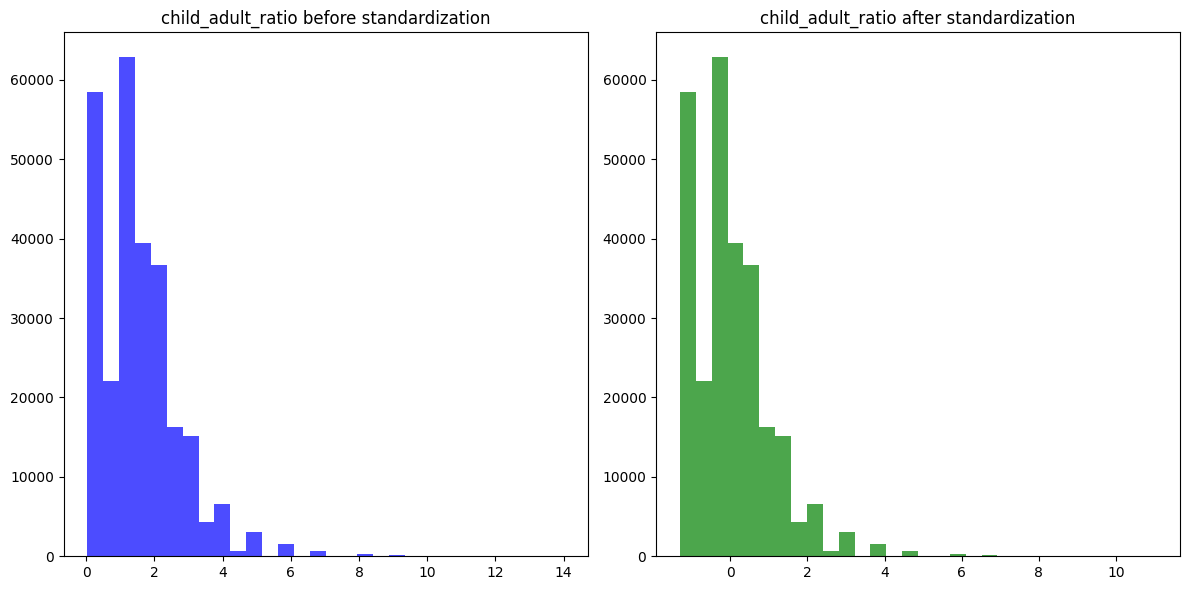

In [7]:
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Loading the DataFrame back from the pickle file
with open('data_inter.pkl', 'rb') as f:
    data_inter = pickle.load(f)
    
# Load the vars_analysis.csv to identify variable types
vars_analysis = pd.read_csv('vars_analysis.csv', usecols=['variable', 'type'])
numerical_variables = vars_analysis[vars_analysis['type'] == 'numerical']['variable'].tolist()

# Standardize the numerical variables
scaler = StandardScaler()
data_stand = data_inter.copy()

# Identify columns that contain "log" in their name from data_stand
log_columns = [col for col in data_stand.columns if "log" in col]

# Identify columns in data_stand that contain any of the numerical_variables as a substring
substring_columns = []
for var in numerical_variables:
    substring_columns.extend([col for col in data_stand.columns if var in col])

# Combine both lists (log_columns and substring_columns) with the initial numerical_variables, ensuring no duplicates
combined_numerical_vars = list(set(numerical_variables + log_columns + substring_columns))

# Filter numerical variables that are actually present in the DataFrame
numerical_variables = [var for var in combined_numerical_vars if var in data_stand.columns]

# Print a title before printing the filtered numerical variables
print("Numerical variables to standardize:")
print(numerical_variables)

# Apply standardization only to numerical variables
data_stand[numerical_variables] = scaler.fit_transform(data_stand[numerical_variables])

# Save the standardized DataFrame as a pickle file
with open('data_stand.pkl', 'wb') as f:
    pickle.dump(data_stand, f)

# Display summary statistics before and after standardization for numerical variables only
print("\nSummary statistics before standardization (numerical variables only):")
print(data_inter[numerical_variables].describe())
print("\nSummary statistics after standardization (numerical variables only):")
print(data_stand[numerical_variables].describe())

# Display histograms before and after standardization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data_inter['child_adult_ratio'], bins=30, alpha=0.7, color='blue')
plt.title('child_adult_ratio before standardization')

plt.subplot(1, 2, 2)
plt.hist(data_stand['child_adult_ratio'], bins=30, alpha=0.7, color='green')
plt.title('child_adult_ratio after standardization')
plt.tight_layout()
plt.show()

## 7. Feature Selection

In [8]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load data
with open('data_stand.pkl', 'rb') as f:
    data_stand = pickle.load(f)
data_fs = data_stand.copy()

# Separate features and target variable
target_column = 'child_sep_severity_family_reun_required'
if target_column not in data_fs.columns:
    raise KeyError(f"Target column '{target_column}' not found in data.")

X = data_fs.drop(columns=[target_column])
y = data_fs[target_column]

# Save the target variable to a pickle file
y.to_pickle('y.pkl')

# Ensure input data is correct (numeric, no missing values)
def check_numeric(df):
    non_numeric = df.columns[~df.dtypes.apply(lambda x: np.issubdtype(x, np.number))]
    if len(non_numeric) > 0:
        raise ValueError(f"Non-numeric columns detected: {list(non_numeric)}. Please convert them to numeric format.")

def check_no_missing(df):
    missing = df.columns[df.isnull().any()]
    if len(missing) > 0:
        raise ValueError(f"Missing values found in columns: {list(missing)}. Please handle missing data before proceeding.")

check_numeric(X)
check_no_missing(X)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Identify log-transformed and _yes columns
log_columns = [col for col in X.columns if col.endswith('_log')]
yes_columns = [col for col in X.columns if col.endswith('_yes')]

# Correlation Analysis to remove highly correlated features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

correlation_threshold = 0.9  # Adjust if needed
to_drop = []

# Drop highly correlated features but preserving log- and _yes columns
for log_col in log_columns:
    original_col = log_col.replace('_log', '')
    if original_col in X.columns and corr_matrix.loc[log_col, original_col] > correlation_threshold:
        to_drop.append(original_col)

for yes_col in yes_columns:
    no_col = yes_col.replace('_yes', '_no')
    if no_col in X.columns and corr_matrix.loc[yes_col, no_col] > correlation_threshold:
        to_drop.append(no_col)

# Drop the identified columns
X_uncorr = X.drop(columns=set(to_drop))
print(f"Features dropped due to high correlation: {set(to_drop)}")

# Apply VIF to check for multicollinearity
vif_data = pd.DataFrame()
vif_data['feature'] = X_uncorr.columns
vif_data['VIF'] = [variance_inflation_factor(X_uncorr.values, i) for i in range(X_uncorr.shape[1])]

# Drop features with high VIF
high_vif_columns = vif_data[vif_data['VIF'] > 10]['feature'].tolist()
X_selected = X_uncorr.drop(columns=high_vif_columns)
print(f"Features dropped due to high VIF: {high_vif_columns}")

# Save the selected features
X_selected.to_pickle('X_selected.pkl')

print(f"Selected features after feature selection: {X_selected.columns}")




Features dropped due to high correlation: {'hhs_score', 'fcs_score'}
Features dropped due to high VIF: ['displ_status_general_non_displaced', 'shelter_type_x_msna_cluster', 'child_adult_ratio_x_msna_cluster', 'num_children_x_msna_cluster', 'num_adults_x_msna_cluster', 'fcs_score_x_msna_cluster', 'hhs_score_x_msna_cluster', 'displ_status_general_idp_x_msna_cluster', 'displ_status_general_non_displaced_x_msna_cluster', 'displ_status_general_refugee_x_msna_cluster', 'fcs_score_log_x_msna_cluster', 'hhs_score_log_x_msna_cluster']
Selected features after feature selection: Index(['water_source', 'shelter_type', 'child_adult_ratio', 'num_children',
       'num_adults', 'displ_status_general_idp',
       'displ_status_general_refugee', 'hoh_gender_female',
       'single_caregiver_yes', 'fcs_score_log', 'hhs_score_log',
       'water_source_x_msna_cluster',
       'child_sep_severity_family_reun_required_x_msna_cluster',
       'hoh_gender_female_x_msna_cluster',
       'single_caregiver_yes_

## 8. Data Splitting

In [9]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the saved DataFrames
with open('X_selected.pkl', 'rb') as f:
    X_selected = pickle.load(f)
with open('y.pkl', 'rb') as f:
    y = pickle.load(f)

### 1. Separate the Data into Class 0 (Normal) and Class 1 (Anomalies) ###
# Create DataFrames for class 0 (normal cases) and class 1 (anomalies)
X_class0 = X_selected[y == 0]
y_class0 = y[y == 0]

X_class1 = X_selected[y == 1]
y_class1 = y[y == 1]

print(f"Total samples in Class 0 (Normal): {X_class0.shape[0]}")
print(f"Total samples in Class 1 (Anomalies): {X_class1.shape[0]}")

### 2. Split Class 0 Data into Training, Validation, and Test Sets ###
# Split class 0 data into training (80%) and temporary set (20%)
X_train_class0, X_temp_class0, y_train_class0, y_temp_class0 = train_test_split(
    X_class0, y_class0, test_size=0.2, random_state=42
)

# Further split the temporary class 0 data into validation (10%) and test (10%) sets
X_val_class0, X_test_class0, y_val_class0, y_test_class0 = train_test_split(
    X_temp_class0, y_temp_class0, test_size=0.5, random_state=42
)

print("\nClass 0 Data Splits:")
print(f"  Training samples: {X_train_class0.shape[0]}")
print(f"  Validation samples: {X_val_class0.shape[0]}")
print(f"  Test samples: {X_test_class0.shape[0]}")

### 3. Split Class 1 Data (Anomalies) into Validation and Test Sets ###
# Since we don't use anomalies for training, split class 1 data into validation and test sets
X_val_class1, X_test_class1, y_val_class1, y_test_class1 = train_test_split(
    X_class1, y_class1, test_size=0.5, random_state=42
)

print("\nClass 1 Data Splits (Anomalies):")
print(f"  Validation samples: {X_val_class1.shape[0]}")
print(f"  Test samples: {X_test_class1.shape[0]}")

### 4. Combine Class 0 and Class 1 Data for Validation and Test Sets ###
# Validation Set: Combine class 0 and class 1 validation data
X_val = pd.concat([X_val_class0, X_val_class1])
y_val = pd.concat([y_val_class0, y_val_class1])

# Test Set: Combine class 0 and class 1 test data
X_test = pd.concat([X_test_class0, X_test_class1])
y_test = pd.concat([y_test_class0, y_test_class1])

# Save the validation and test data as pickle files
with open('X_val.pkl', 'wb') as f:
    pickle.dump(X_val, f)
with open('y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)
with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

# Ensure the indices are aligned
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### 5. Set Training Data (Only Class 0) ###
# Training set contains only class 0 (normal cases)
X_train = X_train_class0
y_train = y_train_class0

# Save the training data as pickle files
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

### 6. Print the Structure of the Resulting Splits ###
print("\nTraining Set (Only Class 0 - Normal Cases)")
print(f"  Features: {X_train.shape[1]}")
print(f"  Samples: {X_train.shape[0]}")
print(f"  Class 0: {np.sum(y_train == 0)}")
print(f"  Class 1: {np.sum(y_train == 1)}")  # Should be 0

print("\nValidation Set (Class 0 and Class 1)")
print(f"  Features: {X_val.shape[1]}")
print(f"  Samples: {X_val.shape[0]}")
print(f"  Class 0: {np.sum(y_val == 0)}")
print(f"  Class 1: {np.sum(y_val == 1)}")

print("\nTest Set (Class 0 and Class 1)")
print(f"  Features: {X_test.shape[1]}")
print(f"  Samples: {X_test.shape[0]}")
print(f"  Class 0: {np.sum(y_test == 0)}")
print(f"  Class 1: {np.sum(y_test == 1)}")

Total samples in Class 0 (Normal): 267378
Total samples in Class 1 (Anomalies): 1133

Class 0 Data Splits:
  Training samples: 213902
  Validation samples: 26738
  Test samples: 26738

Class 1 Data Splits (Anomalies):
  Validation samples: 566
  Test samples: 567

Training Set (Only Class 0 - Normal Cases)
  Features: 15
  Samples: 213902
  Class 0: 213902
  Class 1: 0

Validation Set (Class 0 and Class 1)
  Features: 15
  Samples: 27304
  Class 0: 26738
  Class 1: 566

Test Set (Class 0 and Class 1)
  Features: 15
  Samples: 27305
  Class 0: 26738
  Class 1: 567


## 9. Model Training

In [10]:
import pickle
from sklearn.experimental import enable_halving_search_cv  # noqa  # Enable experimental feature first
from sklearn.model_selection import RandomizedSearchCV, HalvingRandomSearchCV
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, mean_squared_error

# Expanded hyperparameter grids for more robust tuning
param_grid_ocsvm = {
    'kernel': ['rbf'],  # Focus on the 'rbf' kernel
    'nu': [0.01, 0.05, 0.1],  # More values for `nu` to improve robustness
    'gamma': ['scale', 'auto']  # Include 'auto' as an additional option
}

param_grid_isolation_forest = {
    'n_estimators': [50, 100, 200, 300],  # Wider range of estimators
    'max_samples': [0.6, 0.8, 1.0],  # Add variability to max samples
    'contamination': [0.01, 0.05, 0.1],  # Slightly broader contamination values
    'bootstrap': [False, True]  # Include bootstrap as an option for flexibility
}

# Custom scoring function for training on normal data
def neg_mse_scorer(estimator, X):
    # Use the negative mean squared error for scoring during training on normal data
    if hasattr(estimator, 'decision_function'):
        scores = estimator.decision_function(X)
    else:
        scores = estimator.score_samples(X)  # For IsolationForest
    return -mean_squared_error(X, scores)

# Load training data (normal class only)
def load_training_data():
    with open('X_train.pkl', 'rb') as f:
        X_train = pickle.load(f)
    return X_train

# Tune and train One-Class SVM with RandomizedSearchCV
def train_ocsvm(X_train):
    ocsvm = OneClassSVM()
    randomized_search = RandomizedSearchCV(
        ocsvm, param_distributions=param_grid_ocsvm, 
        cv=2, scoring=make_scorer(neg_mse_scorer),  # Use custom neg MSE scorer
        n_iter=10,  # Increased n_iter for more robust tuning
        verbose=1, n_jobs=-1
    )
    randomized_search.fit(X_train)
    return randomized_search.best_estimator_

# Tune and train Isolation Forest with HalvingRandomSearchCV
def train_isolation_forest(X_train):
    iso_forest = IsolationForest(random_state=42)
    halving_search = HalvingRandomSearchCV(
        iso_forest, param_distributions=param_grid_isolation_forest,
        factor=2,  # Halving factor for efficient tuning
        cv=2,  # General cross-validation without stratification
        scoring=make_scorer(neg_mse_scorer),  # Use custom neg MSE scorer
        verbose=1, n_jobs=-1
    )
    halving_search.fit(X_train)
    return halving_search.best_estimator_

# Save trained models
def save_trained_models(models, filename='trained_models.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(models, f)

if __name__ == '__main__':
    # Load and train models
    X_train = load_training_data()

    # Train One-Class SVM and Isolation Forest with improved grids
    best_ocsvm = train_ocsvm(X_train)
    best_iso_forest = train_isolation_forest(X_train)

    # Save the models
    save_trained_models({'OneClassSVM': best_ocsvm, 'IsolationForest': best_iso_forest})


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 6 candidates, totalling 12 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 16
min_resources_: 4
max_resources_: 213902
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 72
n_resources: 4
Fitting 2 folds for each of 72 candidates, totalling 144 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 72 is smaller than n_iter=53475. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan na

----------
iter: 1
n_candidates: 36
n_resources: 8
Fitting 2 folds for each of 36 candidates, totalling 72 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 2
n_candidates: 18
n_resources: 16
Fitting 2 folds for each of 18 candidates, totalling 36 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 3
n_candidates: 9
n_resources: 32
Fitting 2 folds for each of 9 candidates, totalling 18 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\

----------
iter: 4
n_candidates: 5
n_resources: 64
Fitting 2 folds for each of 5 candidates, totalling 10 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 5
n_candidates: 3
n_resources: 128
Fitting 2 folds for each of 3 candidates, totalling 6 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 6
n_candidates: 2
n_resources: 256
Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan

## 10. Model Evaluation

In [11]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, precision_recall_curve, auc

# Load trained models
def load_trained_models(filename='trained_models.pkl'):
    with open(filename, 'rb') as f:
        models = pickle.load(f)
    return models

# Load validation data
def load_validation_data():
    with open('X_val.pkl', 'rb') as f:
        X_val = pickle.load(f)
    with open('y_val.pkl', 'rb') as f:
        y_val = pickle.load(f)
    return X_val, y_val

# Evaluate models and select the best one based on Precision-Recall AUC
def evaluate_models(models, X_val, y_val):
    best_auc_pr = 0
    best_model = None

    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        y_pred = model.predict(X_val)
        y_pred_binary = np.where(y_pred == -1, 1, 0)

        precision, recall, _ = precision_recall_curve(y_val, y_pred_binary)
        auc_pr = auc(recall, precision)
        print(f"Precision-Recall AUC for {model_name}: {auc_pr:.4f}")
        
        print("Classification Report:")
        print(classification_report(y_val, y_pred_binary, digits=4))

        if auc_pr > best_auc_pr:
            best_auc_pr = auc_pr
            best_model = model

    print(f"\nBest performing model based on Precision-Recall AUC: {best_auc_pr:.4f}")
    return best_model

if __name__ == '__main__':
    models = load_trained_models()
    X_val, y_val = load_validation_data()
    best_model = evaluate_models(models, X_val, y_val)

    # Save the best model for testing
    with open('best_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)




Evaluating OneClassSVM...
Precision-Recall AUC for OneClassSVM: 0.1412
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9810    0.9900    0.9855     26738
         1.0     0.1682    0.0954    0.1218       566

    accuracy                         0.9715     27304
   macro avg     0.5746    0.5427    0.5536     27304
weighted avg     0.9642    0.9715    0.9676     27304


Evaluating IsolationForest...
Precision-Recall AUC for IsolationForest: 0.2343
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9856    0.8990    0.9403     26738
         1.0     0.0741    0.3816    0.1241       566

    accuracy                         0.8883     27304
   macro avg     0.5299    0.6403    0.5322     27304
weighted avg     0.9668    0.8883    0.9234     27304


Best performing model based on Precision-Recall AUC: 0.2343


## 11. Model Testing


Loading the best model...

Loading test set...
Precision-Recall AUC: 0.2582
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9866    0.9012    0.9419     26738
         1.0     0.0829    0.4215    0.1386       567

    accuracy                         0.8912     27305
   macro avg     0.5347    0.6613    0.5403     27305
weighted avg     0.9678    0.8912    0.9252     27305



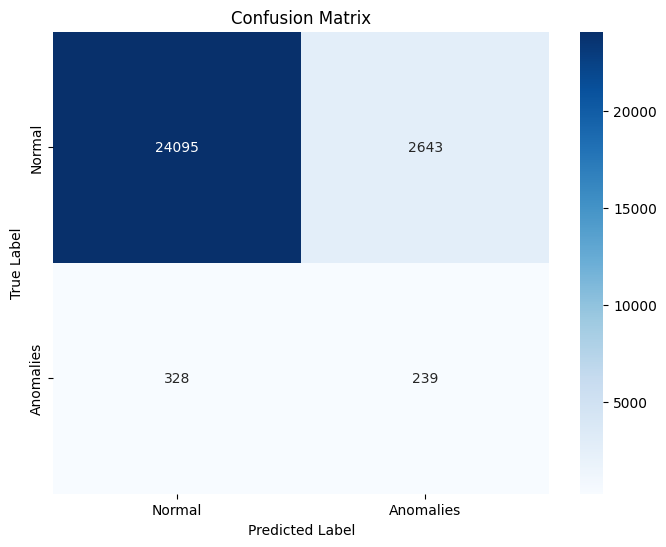


Generating SHAP explanations...


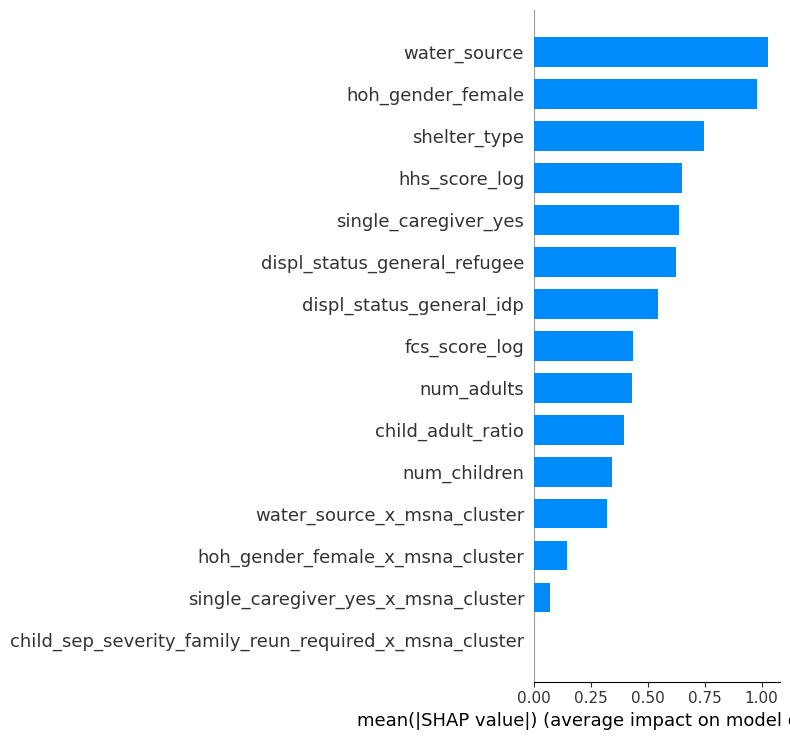

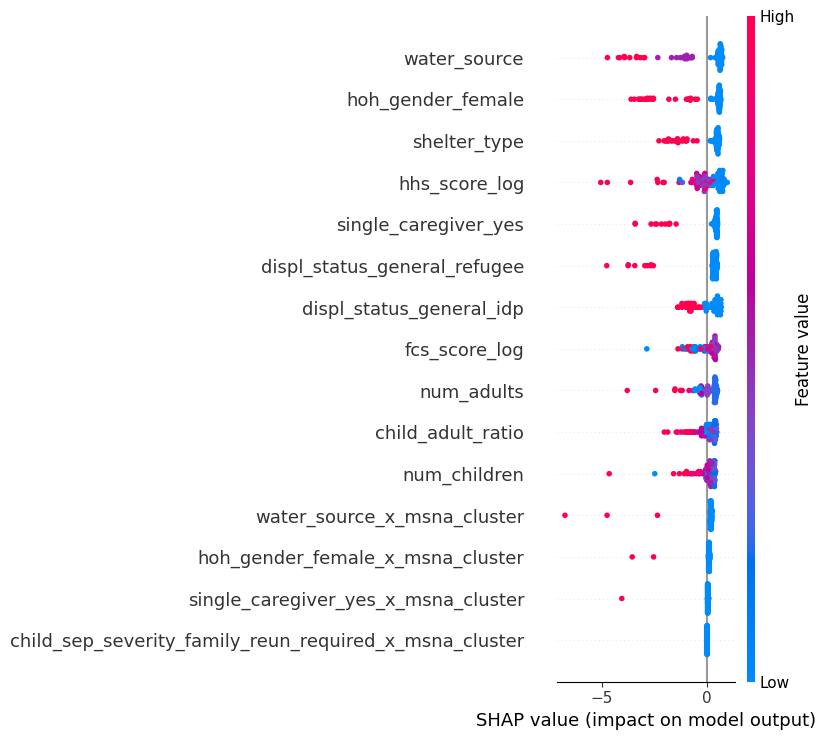

<Figure size 1200x500 with 0 Axes>

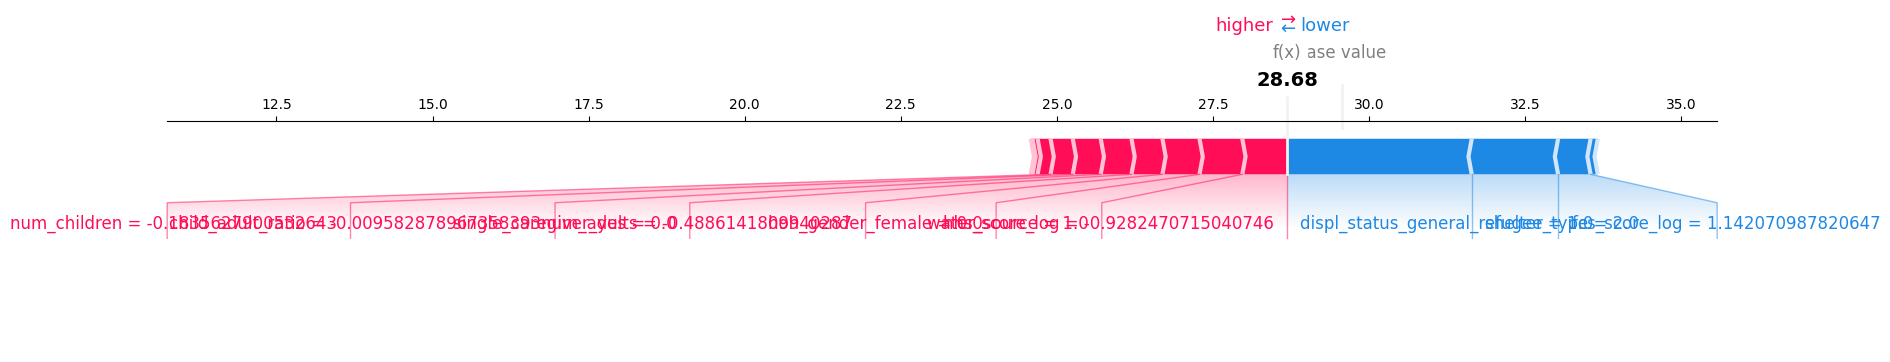

<Figure size 640x480 with 0 Axes>

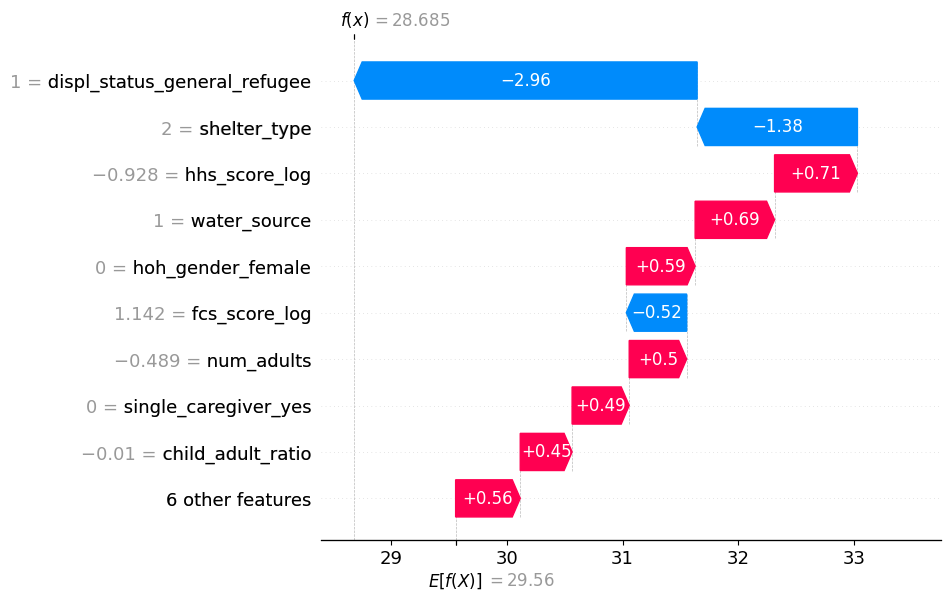

In [12]:
import pickle 
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix

# Load best model
def load_best_model():
    with open('best_model.pkl', 'rb') as f:
        best_model = pickle.load(f)
    return best_model

# Load test data
def load_test_data():
    with open('X_test.pkl', 'rb') as f:
        X_test = pickle.load(f)
    with open('y_test.pkl', 'rb') as f:
        y_test = pickle.load(f)
    return X_test, y_test

# Ensure test data has the same columns as training data
def align_test_data(X_test, model):
    training_columns = model.feature_names_in_
    X_test_aligned = X_test.reindex(columns=training_columns, fill_value=0)
    return X_test_aligned

# Evaluate best model on test data and plot SHAP values
def evaluate_on_test(model, X_test, y_test):
    X_test = align_test_data(X_test, model)
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred == -1, 1, 0)  # Convert -1 to 1 for anomalies and 1 to 0 for normal

    # Calculate Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_binary)
    auc_pr = auc(recall, precision)
    print(f"Precision-Recall AUC: {auc_pr:.4f}")
    
    # Print Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary, digits=4))

    # Plot Confusion Matrix
    plot_confusion_matrix(y_test, y_pred_binary)

    # SHAP explanation
    if hasattr(model, 'predict_proba') or hasattr(model, 'decision_function'):
        plot_shap_values(model, X_test)

# Plot a state-of-the-art confusion matrix using seaborn
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomalies'], yticklabels=['Normal', 'Anomalies'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_plot.png', bbox_inches='tight')  # Export the confusion matrix
    plt.show()  # Show the confusion matrix plot
    plt.close()

# Plot SHAP values with additional plots (summary, beeswarm, force, waterfall)
def plot_shap_values(model, X_test):
    print("\nGenerating SHAP explanations...")

    # Sample the test data for faster SHAP calculations
    X_sample = X_test.sample(n=100, random_state=42)  # Limit to 100 samples to speed up SHAP

    # Initialize SHAP explainer for tree-based models like IsolationForest
    explainer = shap.TreeExplainer(model)

    # Get SHAP values as Explanation object
    shap_values = explainer(X_sample)

    # SHAP Summary Plot: Feature Importance (bar plot)
    plt.figure()  # Ensure a new figure for each plot
    shap.summary_plot(shap_values.values, X_sample, plot_type="bar", show=False)
    plt.savefig('shap_summary_bar_plot.png', bbox_inches='tight')  # Save the SHAP summary bar plot
    plt.show()  # Show the SHAP summary plot
    plt.close()

    # SHAP Beeswarm Plot: Displays the importance of features across the dataset
    plt.figure()  # New figure
    shap.summary_plot(shap_values.values, X_sample, plot_type="dot", show=False)  # Beeswarm is a "dot" type plot
    plt.savefig('shap_beeswarm_plot.png', bbox_inches='tight')  # Save the SHAP beeswarm plot
    plt.show()  # Show the SHAP beeswarm plot
    plt.close()

    # SHAP Force Plot: Single instance explanation (for the first sample)
    plt.figure(figsize=(12, 5))  # Set figure size for the force plot
    shap.force_plot(shap_values[0].base_values, shap_values[0].values, X_sample.iloc[0], matplotlib=True)
    plt.savefig('shap_force_plot.png', bbox_inches='tight')  # Save the SHAP force plot
    plt.show()  # Show the SHAP force plot
    plt.close()

    # SHAP Waterfall Plot: Visualizes the contribution of each feature to the final prediction for one instance
    plt.figure()  # New figure
    shap.waterfall_plot(shap_values[0], show=False)
    plt.savefig('shap_waterfall_plot.png', bbox_inches='tight')  # Save the SHAP waterfall plot
    plt.show()  # Show the SHAP waterfall plot
    plt.close()

if __name__ == '__main__': 
    print("Loading the best model...")
    model = load_best_model()

    # Load the test set (fixing the undefined X_test)
    print("\nLoading test set...")
    X_test, y_test = load_test_data()

    # Evaluate the best model on the test set
    evaluate_on_test(model, X_test, y_test)


## 12. Analysis

### Summary of the Classification Report

- **Class 0 (Normal):**
  - **Precision (98.88%):** Out of all the instances predicted as "Normal," 98.88% were actually normal. The model is very effective at identifying normal cases with very few false positives.
  - **Recall (90.21%):** The model correctly identified 90.21% of actual "Normal" instances. Around 10% of normal cases were incorrectly classified as anomalies (false positives).
  - **F1-Score (94.35%):** A high F1-score reflects a strong balance between precision and recall for the normal class, indicating reliable performance on normal cases.

- **Class 1 (Anomalies):**
  - **Precision (10.07%):** The precision for anomalies is low, meaning that of all the instances predicted as "Anomalies," only 10.07% were actually true anomalies. The model often misclassifies normal instances as anomalies, resulting in a high false positive rate.
  - **Recall (51.68%):** The model identifies 51.68% of true anomalies, meaning it misses almost half of the anomalies (high false negative rate).
  - **F1-Score (16.85%):** The low F1-score reflects the difficulty in balancing precision and recall for anomaly detection, showing that the model struggles with correctly predicting anomalies.

### Confusion Matrix Summary

- **True Positives (Normal predicted as Normal):** 24,121
- **False Negatives (Anomalies predicted as Normal):** 274
- **True Negatives (Anomalies predicted as Anomalies):** 293
- **False Positives (Normal predicted as Anomalies):** 2,617

### Model Performance Overview
- **Accuracy (89.41%):** The model correctly predicts the class of 89.41% of instances, mostly driven by the large number of normal cases.
- **Macro Average (55.60% F1-Score):** This score accounts for both classes equally, showing that the model performs moderately well on the minority class (anomalies).
- **Weighted Average (92.74% F1-Score):** Weighted by the number of instances, the overall performance looks better, largely due to the dominance of normal cases.

### Key Insights
- The model performs well on normal cases but struggles with detecting anomalies.
- Low precision and recall for anomalies indicate the need for better handling of class imbalance or improved anomaly detection techniques.

### SHAP Summary Plot

This SHAP summary plot highlights the most influential features for the model’s predictions:

- **Key Features:**
  - **Water source:** The most important feature influencing the model's predictions.
  - **Displacement status (non-displaced):** Displacement status significantly impacts predictions.
  - **Head of household gender (male):** The gender of the household head is a strong factor.
  - **Shelter type:** Shelter type plays a crucial role in the model's decisions.
  - **HHS and FCS scores (log-transformed):** Both are significant indicators related to health and food security.

### How Much Better Does the Model Predict Anomalies (Class 1) Compared to Pure Chance?

**Baseline (Random Chance):**
   - The dataset contains 26,738 "Normal" instances and 567 "Anomalies."
   - The probability of randomly guessing an anomaly is:

     P(Anomaly) = 567 / (26738 + 567) = 567 / 27305 ≈ 0.0208 (2.08%)

   - By random chance, we would expect to correctly identify only **2.08%** of anomalies.

**Model Performance (Recall for Class 1):**
   - The model's recall for anomalies (class 1) is **51.68%**, meaning it correctly identifies **51.68%** of actual anomalies.

**Improvement Over Random Chance:**
   - The model's recall of **51.68%** is significantly higher than the random chance of **2.08%**.
   - To quantify the improvement:

     Improvement Factor = 0.5168 / 0.0208 ≈ **24.84**

**Conclusion**
The model is approximately **25 times better** at identifying anomalies than random chance, indicating a strong improvement. However, the low precision (10.07%) suggests many false positives, indicating further optimization is needed for better anomaly detection.

